<a href="https://colab.research.google.com/github/KatBotkowska/CodersCrew/blob/master/Netflix_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pobranie danych z Kaggle


###https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

##Importy - do przeniesienia z treści niżej

In [14]:
import pandas as pd
import numpy as np


In [15]:
#podłączenie google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
root_path = 'gdrive/My Drive/netflix/'

In [4]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kbotkowska","key":"90ebb11108c952959800f5549af3472d"}'}

In [5]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


##Pobranie i rozpakowanie danych kaggle - netflix

In [ ]:
!kaggle datasets download -d shivamb/netflix-shows

401 - Unauthorized


In [ ]:
!unzip -q netflix-shows.zip -d [netflix]

replace [netflix]/netflix_titles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

##Pobranie i rozpakowanie danych kaggle - imdb

In [6]:
!kaggle datasets download -d stefanoleone992/imdb-extensive-dataset

 98% 81.0M/82.3M [00:01<00:00, 52.0MB/s]
100% 82.3M/82.3M [00:01<00:00, 74.1MB/s]


In [7]:
!unzip -q imdb-extensive-dataset.zip -d [netflix]

##Pobranie i rozpakowanie danych kaggle - movielens

In [ ]:
!kaggle datasets download -d grouplens/movielens-20m-dataset

 94% 184M/195M [00:01<00:00, 88.5MB/s]
100% 195M/195M [00:01<00:00, 105MB/s] 


In [ ]:
!unzip -q movielens-20m-dataset.zip -d [netflix]

##Załadowanie dataframes

In [ ]:
import pandas as pd
#netflix_titles = pd.read_csv('/content/[netflix]/netflix_titles.csv')

In [8]:
imdb_movies = pd.read_csv('/content/[netflix]/IMDb movies.csv')
imdb_names = pd.read_csv('/content/[netflix]/IMDb names.csv')
imdb_ratings = pd.read_csv('/content/[netflix]/IMDb ratings.csv')
imdb_title_principals = pd.read_csv('/content/[netflix]/IMDb title_principals.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
movielens_genome_scores = pd.read_csv('/content/[netflix]/genome_scores.csv')
movielens_genome_tags = pd.read_csv('/content/[netflix]/genome_tags.csv')
movielens_link = pd.read_csv('/content/[netflix]/link.csv')
movielens_movie = pd.read_csv('/content/[netflix]/movie.csv')
movielens_rating = pd.read_csv('/content/[netflix]/rating.csv')
movielens_tag = pd.read_csv('/content/[netflix]/tag.csv')

FileNotFoundError: ignored

##Czyszczenie danych
zamiana wiersza z TV movie 2019 na 2019
dtypes z object na właściwe
NaN??
gatunki zamiana ze stringa na listy tagów


#Netflix - podstawowe dane


In [ ]:
netflix_titles.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [ ]:
netflix_titles.shape
#rozmiary  - wiersze i kolumny

(6234, 12)

In [ ]:
netflix_titles.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6234 non-null   int64 
 1   type          6234 non-null   object
 2   title         6234 non-null   object
 3   director      4265 non-null   object
 4   cast          5664 non-null   object
 5   country       5758 non-null   object
 6   date_added    6223 non-null   object
 7   release_year  6234 non-null   int64 
 8   rating        6224 non-null   object
 9   duration      6234 non-null   object
 10  listed_in     6234 non-null   object
 11  description   6234 non-null   object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB


In [ ]:
netflix_titles.describe()
#trochę bez sensu, nie ma tutaj dużo danych numerycznych do podsumowań

,show_id,release_year
count,6.234000e+03,6234.00000
mean,7.670368e+07,2013.35932
std,1.094296e+07,8.81162
min,2.477470e+05,1925.00000
25%,8.003580e+07,2013.00000
50%,8.016337e+07,2016.00000
75%,8.024489e+07,2018.00000
max,8.123573e+07,2020.00000


##Netflix dla 2019

In [ ]:
netflix_2019 = netflix_titles.iloc[:,:][netflix_titles.release_year==2019]
netflix_2019.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
34,80221550,TV Show,Archibald's Next Big Thing,NaN,"Tony Hale, Rosamund Pike, Jordan Fisher, Chels...",NaN,"September 6, 2019",2019,TV-Y7,1 Season,"Kids' TV, TV Comedies",Happy-go-lucky chicken Archibald may not remem...
35,81154455,Movie,Article 15,Anubhav Sinha,"Ayushmann Khurrana, Nassar, Manoj Pahwa, Kumud...",India,"September 6, 2019",2019,TV-MA,125 min,"Dramas, International Movies, Thrillers",The grim realities of caste discrimination com...
38,81132437,Movie,Kill Me If You Dare,Şenol Sönmez,"Murat Boz, Seda Bakan, Açelya Topaloğlu, Özgür...",NaN,"September 6, 2019",2019,TV-14,100 min,"Comedies, International Movies, Romantic Movies","Bogged down with money problems, a couple grow..."
39,80178151,TV Show,The Spy,NaN,"Sacha Baron Cohen, Noah Emmerich, Hadar Ratzon...",France,"September 6, 2019",2019,TV-MA,1 Season,"International TV Shows, TV Dramas, TV Thrillers","In the 1960s, Israeli clerk-turned-secret agen..."


In [ ]:
netflix_2019.shape

(843, 12)

In [ ]:
imdb_movies.tail()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
85850,tt9908390,Le lion,Le lion,2020,2020-01-29,Comedy,95,"France, Belgium",French,Ludovic Colbeau-Justin,"Alexandre Coquelle, Matthieu Le Naour",Monkey Pack Films,"Dany Boon, Philippe Katerine, Anne Serra, Samu...",A psychiatric hospital patient pretends to be ...,5.3,398,NaN,NaN,$ 3507171,NaN,NaN,4.0
85851,tt9911196,De Beentjes van Sint-Hildegard,De Beentjes van Sint-Hildegard,2020,2020-02-13,"Comedy, Drama",103,Netherlands,"German, Dutch",Johan Nijenhuis,"Radek Bajgar, Herman Finkers",Johan Nijenhuis & Co,"Herman Finkers, Johanna ter Steege, Leonie ter...",A middle-aged veterinary surgeon believes his ...,7.7,724,NaN,NaN,$ 7299062,NaN,6.0,4.0
85852,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,2019-03-08,Drama,130,India,Malayalam,Vineesh Aaradya,"Vineesh Aaradya, Vineesh Aaradya",RMCC Productions,"Anoop Chandran, Indrans, Sona Nair, Simon Brit...",NaN,7.9,265,NaN,NaN,NaN,NaN,NaN,NaN
85853,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,2019-03-15,"Drama, Family",98,Turkey,Turkish,Ahmet Faik Akinci,"Ahmet Faik Akinci, Kasim Uçkan",Gizem Ajans,"Ahmet Faik Akinci, Belma Mamati, Metin Keçeci,...",NaN,6.4,194,NaN,NaN,$ 2833,NaN,NaN,NaN
85854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,2020-02-05,Drama,74,Spain,Catalan,Laura Jou,"Coral Cruz, Pep Puig",La Xarxa de Comunicació Local,"Maria Morera Colomer, Biel Rossell Pelfort, Is...","Pep, a 13-year-old boy, is in love with a girl...",6.7,102,NaN,NaN,$ 59794,NaN,NaN,2.0


##IMDB dla 2019

In [ ]:
imdb_2019 = imdb_movies.iloc[:,:][imdb_movies.year==2019]
imdb_2019.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
44619,tt0385887,Motherless Brooklyn - I segreti di una città,Motherless Brooklyn,2019,2019-11-07,"Crime, Drama, Mystery",144,USA,"English, French",Edward Norton,"Edward Norton, Jonathan Lethem",Warner Bros. Pictures,"Edward Norton, Gugu Mbatha-Raw, Alec Baldwin, ...","In 1950s New York, a lonely private detective ...",6.8,34759,$ 26000000,$ 9277736,$ 18477736,60.0,319.0,178.0
46723,tt0437086,Alita - Angelo della battaglia,Alita: Battle Angel,2019,2019-02-14,"Action, Adventure, Sci-Fi",122,"USA, Japan, Canada","English, Spanish",Robert Rodriguez,"James Cameron, Laeta Kalogridis",Twentieth Century Fox,"Rosa Salazar, Christoph Waltz, Jennifer Connel...","A deactivated cyborg is revived, but cannot re...",7.3,217183,$ 170000000,$ 85710210,$ 404852543,53.0,2757.0,368.0
46892,tt0441881,La battaglia di Long Tan,Danger Close: The Battle of Long Tan,2019,2019-08-08,"Action, Drama, War",118,Australia,English,Kriv Stenders,"Stuart Beattie, James Nicholas",Deeper Water,"Travis Fimmel, Toby Blome, Alexander England, ...","In August 1966, in a Vietnamese rubber plantat...",6.8,8131,AUD 24000000,NaN,$ 2078370,NaN,204.0,31.0
47132,tt0448115,Shazam!,Shazam!,2019,2019-04-03,"Action, Adventure, Comedy",132,"USA, Canada","English, Spanish",David F. Sandberg,"Henry Gayden, Henry Gayden",Warner Bros.,"Zachary Levi, Mark Strong, Asher Angel, Jack D...",A newly fostered young boy in search of his mo...,7.1,240858,$ 100000000,$ 140371656,$ 365971656,71.0,2009.0,379.0
49759,tt0783640,Era mio figlio,The Last Full Measure,2019,2020-04-02,"Drama, War",116,USA,English,Todd Robinson,Todd Robinson,Foresight Unlimited,"Sebastian Stan, Alison Sudol, Asher Miles Fall...","Thirty-four years after his death, Airman Will...",6.7,5449,$ 20000000,$ 2949212,$ 3364426,51.0,163.0,44.0


##Łączenie IMDB i Netflix dla 2019

In [ ]:
netflix_imdb_2019 = pd.merge(netflix_2019, imdb_2019, on=['title'])
netflix_imdb_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 0 to 22
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   show_id                23 non-null     int64  
 1   type                   23 non-null     object 
 2   title                  23 non-null     object 
 3   director_x             22 non-null     object 
 4   cast                   23 non-null     object 
 5   country_x              22 non-null     object 
 6   date_added             23 non-null     object 
 7   release_year           23 non-null     int64  
 8   rating                 23 non-null     object 
 9   duration_x             23 non-null     object 
 10  listed_in              23 non-null     object 
 11  description_x          23 non-null     object 
 12  imdb_title_id          23 non-null     object 
 13  original_title         23 non-null     object 
 14  year                   23 non-null     object 
 15  date_pub

In [ ]:
netflix_imdb_2019.shape

(23, 33)

In [ ]:
netflix_imdb_2019

##Łączenie IMDB i Netflix dla wszystkich danych

In [ ]:
netflix_imdb_all = pd.merge(netflix_titles, imdb_movies, on=['title'])
netflix_imdb_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2332 entries, 0 to 2331
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   show_id                2332 non-null   int64  
 1   type                   2332 non-null   object 
 2   title                  2332 non-null   object 
 3   director_x             2026 non-null   object 
 4   cast                   2283 non-null   object 
 5   country_x              2278 non-null   object 
 6   date_added             2330 non-null   object 
 7   release_year           2332 non-null   int64  
 8   rating                 2331 non-null   object 
 9   duration_x             2332 non-null   object 
 10  listed_in              2332 non-null   object 
 11  description_x          2332 non-null   object 
 12  imdb_title_id          2332 non-null   object 
 13  original_title         2332 non-null   object 
 14  year                   2332 non-null   object 
 15  date

In [ ]:
netflix_imdb_all.head()

,show_id,type,title,director_x,cast,country_x,date_added,release_year,rating,duration_x,listed_in,description_x,imdb_title_id,original_title,year,date_published,genre,duration_y,country_y,language,director_y,writer,production_company,actors,description_y,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,tt9428190,Norm of the North: King Sized Adventure,2019,2019-08-02,"Animation, Adventure, Comedy",90,"USA, India, South Korea, China",English,"Richard Finn, Tim Maltby",Dean Stefan,Assemblage,"Alan Marriott, Andrew Toth, Brian Dobson, Cole...",An ancient Chinese artifact has been stolen by...,3.2,284,NaN,NaN,$ 1505059,NaN,13.0,4.0
1,70304989,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada","September 8, 2017",2014,R,110 min,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f...",tt1971325,Autómata,2014,2015-02-26,"Action, Drama, Sci-Fi",109,"Spain, Bulgaria",English,Gabe Ibáñez,"Gabe Ibáñez, Igor Legarreta",Green Moon,"Antonio Banderas, Dylan McDermott, Melanie Gri...",Human race is at edge of the end. Robot race i...,6.1,53583,$ 7000000,NaN,$ 6237990,37.0,176.0,151.0
2,70304989,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada","September 8, 2017",2014,R,110 min,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f...",tt8339704,Automata,2019,2020-01-27,Horror,95,UK,English,Lawrie Brewster,Sarah Daly,Hex Studios,"Jamie Scott Gordon, Jonathan Hansler, Alexandr...",Antique expert Brendon Cole is sent to authent...,4.3,314,NaN,NaN,NaN,NaN,39.0,5.0
3,70304990,Movie,Good People,Henrik Ruben Genz,"James Franco, Kate Hudson, Tom Wilkinson, Omar...","United States, United Kingdom, Denmark, Sweden","September 8, 2017",2014,R,90 min,"Action & Adventure, Thrillers",A struggling couple can't believe their luck w...,tt1361318,Good People,2014,2015-08-21,"Action, Crime, Thriller",90,"USA, UK, Denmark, Sweden",English,Henrik Ruben Genz,"Marcus Sakey, Kelly Masterson",Millennium Films,"Sam Spruell, Michael Fox, Diarmaid Murtagh, Fr...",Discovering a stash of cash in their dead tena...,5.5,15257,NaN,NaN,$ 1857574,42.0,56.0,57.0
4,80057969,Movie,Love,Gaspar Noé,"Karl Glusman, Klara Kristin, Aomi Muyock, Ugo ...","France, Belgium","September 8, 2017",2015,NR,135 min,"Cult Movies, Dramas, Independent Movies",A man in an unsatisfying marriage recalls the ...,tt0392360,Love,1991,1991-11-15,"Drama, Musical, Romance",152,India,Hindi,Suresh Krishna,NaN,NaN,"Salman Khan, Revathi, Rita Bhaduri, Shafi Inam...",Prithvi and Maggie fall in love and decide to ...,5.7,1003,NaN,NaN,NaN,NaN,6.0,NaN


In [ ]:
imdb_movies.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

# Szeregi czasowe - jak przez lata zmieniała się liczba wydawanych filmów? - Ewa

In [ ]:
import pandas as pd
imdb_movies = pd.read_csv('/content/[netflix]/IMDb movies.csv')

imdb_movies.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0


In [ ]:
imdb_movies.dtypes

imdb_title_id             object
title                     object
original_title            object
year                      object
date_published            object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
writer                    object
production_company        object
actors                    object
description               object
avg_vote                 float64
votes                      int64
budget                    object
usa_gross_income          object
worlwide_gross_income     object
metascore                float64
reviews_from_users       float64
reviews_from_critics     float64
dtype: object

In [ ]:
imdb_movies.groupby('year').imdb_title_id.count()

year
1894                1
1906                1
1911                5
1912                5
1913               13
                 ... 
2017             3223
2018             3182
2019             2168
2020              401
TV Movie 2019       1
Name: imdb_title_id, Length: 168, dtype: int64

In [ ]:
imdb_movies[imdb_movies.year == 'TV Movie 2019']

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
83917,tt8206668,Bad Education,Bad Education,TV Movie 2019,TV Movie 2019,"Biography, Comedy, Crime",108,USA,English,Cory Finley,"Mike Makowsky, Robert Kolker",HBO Films,"Hugh Jackman, Ray Romano, Welker White, Alliso...",The beloved superintendent of New York's Rosly...,7.1,23973,NaN,NaN,NaN,79.0,135.0,98.0


In [ ]:
imdb_movies.loc[83917, 'year'] = 2019
imdb_movies.year = imdb_movies.year.astype('int')
imdb_movies.dtypes

imdb_title_id             object
title                     object
original_title            object
year                       int64
date_published            object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
writer                    object
production_company        object
actors                    object
description               object
avg_vote                 float64
votes                      int64
budget                    object
usa_gross_income          object
worlwide_gross_income     object
metascore                float64
reviews_from_users       float64
reviews_from_critics     float64
dtype: object

In [124]:
data_year_plot = imdb_movies.groupby('year').imdb_title_id.count()
data_year_plot.tail(20)

year
2002                3
2003                9
2004                7
2005               15
2006               14
2007               23
2008               11
2009               18
2010               24
2011               65
2012              847
2013             1916
2014             2517
2015             2764
2016             2992
2017             3223
2018             3182
2019             2168
2020              401
TV Movie 2019       1
Name: imdb_title_id, dtype: int64

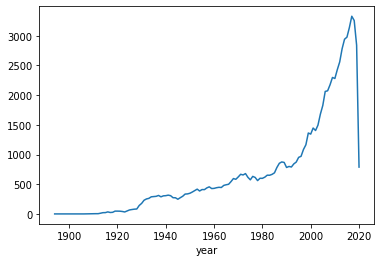

In [ ]:
import matplotlib.pyplot as plt

data_year_plot.plot()
plt.show()

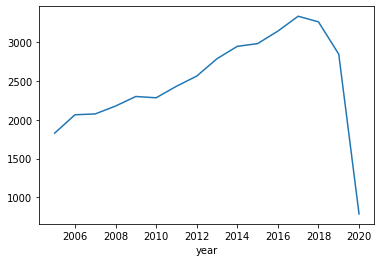

In [ ]:
data_year_plot_from2004 = imdb_movies[imdb_movies.year > 2004].groupby('year').imdb_title_id.count()
data_year_plot_from2004.plot()

# chyba nie ma sensu brać do analizy roku 2020. zastanawiam się nad 2019 - czy przez covida tak mało, czy też braki danych.

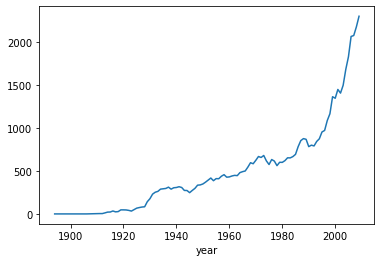

In [ ]:
data_year_plot_to2009 = imdb_movies[imdb_movies.year <= 2009].groupby('year').imdb_title_id.count()
data_year_plot_to2009.plot()

In [ ]:
imdb_movies.loc[83917, 'date_published'] = '2019-01-01' #ustawiam 1 stycznia jako datę publikacji tego dziwnego filmu

pd.to_datetime(imdb_movies['date_published'])

0       1894-10-09
1       1906-12-26
2       1911-08-19
3       1912-11-13
4       1911-03-06
           ...    
85850   2020-01-29
85851   2020-02-13
85852   2019-03-08
85853   2019-03-15
85854   2020-02-05
Name: date_published, Length: 85855, dtype: datetime64[ns]

In [ ]:
imdb_movies['date_published'].dt.year #nie wiem czemu wyskakuje błąd, dkoro wyżej widać, że ta kolumna już jest typem datetime

AttributeError: ignored

#Na lata jakie rodzaje filmów dominują, jakie trendy w gatunkach - KASIA

In [90]:

imdb_movies = pd.read_csv('/content/[netflix]/IMDb movies.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


##Najczęściej występujące gatunki

In [104]:
imdb_movies['genre'].value_counts().head(10)

Drama                     12543
Comedy                     7693
Comedy, Drama              4039
Drama, Romance             3455
Comedy, Romance            2508
Comedy, Drama, Romance     2293
Horror                     2268
Drama, Thriller            1348
Crime, Drama               1343
Action, Crime, Drama       1310
Name: genre, dtype: int64

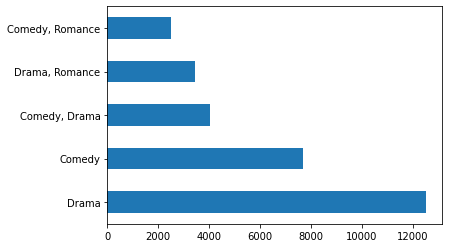

In [105]:
ax = imdb_movies['genre'].value_counts().head().plot.barh( rot=0)

##Ilość gatunków w poszczególnych latach
Widać, że gatunki to 'tagi' opisujące film, do jednego filmu przypisuje się coraz więcej gatunków.

In [106]:
#ilość gatunków w poszczególnych latach
imdb_movies.groupby('year').genre.count().tail(20)

year
2002                3
2003                9
2004                7
2005               15
2006               14
2007               23
2008               11
2009               18
2010               24
2011               65
2012              847
2013             1916
2014             2517
2015             2764
2016             2992
2017             3223
2018             3182
2019             2168
2020              401
TV Movie 2019       1
Name: genre, dtype: int64

##Lista wszystkich gatunków

In [107]:
genres = imdb_movies['genre'].unique().tolist()
genres_all=[]
for genre in genres:
    for elem in genre.split(','):
        genres_all.append(elem.strip())
genres_all=list(set(genres_all))
genres_all

['News',
 'Comedy',
 'Adult',
 'Fantasy',
 'Drama',
 'History',
 'Sci-Fi',
 'Romance',
 'Horror',
 'Mystery',
 'Biography',
 'Family',
 'Music',
 'Documentary',
 'Crime',
 'Sport',
 'Western',
 'Thriller',
 'Action',
 'Animation',
 'War',
 'Film-Noir',
 'Adventure',
 'Musical',
 'Reality-TV']

##Unikalne gatunki - najbardziej popularne

In [114]:
genres = imdb_movies['genre'].tolist()
genres_count=[]
for genre in genres:
    for elem in genre.split(','):
        genres_all.append(elem.strip())
genres_count=list(genres_all)
from collections import Counter
genres_count_all=pd.DataFrame.from_dict(Counter(genres_count), orient='index')
genres_count_all.rename(columns={'index':'genres', 0:'occurences'}, inplace=True)
genres_count_all.sort_values(by='occurences', ascending=False)


,occurences
Drama,94221
Comedy,58737
Romance,28257
Action,25897
Thriller,22777
Crime,22135
Horror,19115
Adventure,15181
Mystery,10451
Family,7925


Text(0.5, 0, 'occurences')

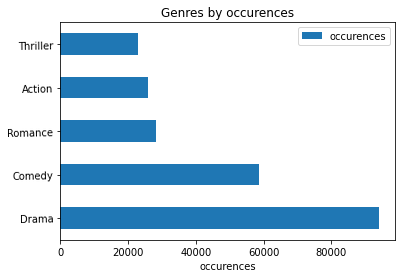

In [115]:
ax = genres_count_all.sort_values(by='occurences', ascending=False).head().plot.barh(rot=1, title='Genres by occurences')
ax.set_xlabel('occurences')
#ax.set_ylabel()


##Gatunki na lata

In [116]:
imdb_movies['genre_list']=imdb_movies['genre'].str.split(',', n=5)
#imdb_movies['genre_list'].value_counts().head(10)

In [117]:
genres_by_years=imdb_movies[['genre', 'year']].groupby(['year', 'genre'], as_index=True)['genre'].count()
genres_by_years.tail(100)

year           genre                     
2020           Adventure, Family              1
               Adventure, Family, Fantasy     3
               Adventure, Horror              1
               Adventure, Romance             1
               Animation                      1
                                             ..
               Sport                          1
               Thriller                      18
               War                            3
               Western                        1
TV Movie 2019  Biography, Comedy, Crime       1
Name: genre, Length: 100, dtype: int64

In [118]:
#dla roku 2019 zamiana str gatunków na listę
genres_split_by_years=imdb_movies[['genre', 'year', 'imdb_title_id']]
genres_split_by_years[genres_split_by_years['year']=='2019']
genres = genres_split_by_years['genre']

new_genres=[]
for genre in genres.to_list():
    genre = genre.split(',')
    new_genres.append(genre)

genres_split_by_years['new_genre']=new_genres
genres_split_by_years


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,genre,year,imdb_title_id,new_genre
0,Romance,1894,tt0000009,[Romance]
1,"Biography, Crime, Drama",1906,tt0000574,"[Biography, Crime, Drama]"
2,Drama,1911,tt0001892,[Drama]
3,"Drama, History",1912,tt0002101,"[Drama, History]"
4,"Adventure, Drama, Fantasy",1911,tt0002130,"[Adventure, Drama, Fantasy]"
...,...,...,...,...
85850,Comedy,2020,tt9908390,[Comedy]
85851,"Comedy, Drama",2020,tt9911196,"[Comedy, Drama]"
85852,Drama,2019,tt9911774,[Drama]
85853,"Drama, Family",2019,tt9914286,"[Drama, Family]"


In [119]:
genres_in_2019 = genres_split_by_years[genres_split_by_years['year']=='2019']
genres_2019=genres_in_2019['new_genre'].to_list()
genres_2019

[['Crime', ' Drama'],
 ['Action', ' Adventure', ' Fantasy'],
 ['Drama'],
 ['Drama', ' Romance'],
 ['Action', ' Adventure', ' Comedy'],
 ['Comedy', ' Drama'],
 ['Mystery', ' Thriller'],
 ['Comedy', ' Drama'],
 ['Animation', ' Action', ' Adventure'],
 ['Action', ' Crime', ' Drama'],
 ['Drama', ' Music'],
 ['Drama', ' History', ' Thriller'],
 ['Comedy', ' Drama', ' Family'],
 ['Comedy', ' Fantasy', ' Romance'],
 ['Biography', ' Crime', ' Drama'],
 ['Action', ' Crime', ' Drama'],
 ['Action', ' Adventure', ' Fantasy'],
 ['Comedy', ' Drama', ' War'],
 ['Adventure', ' Comedy', ' Drama'],
 ['Comedy', ' Family'],
 ['Drama', ' Horror', ' Mystery'],
 ['Drama', ' Thriller'],
 ['Drama', ' Family', ' Sci-Fi'],
 ['Adventure', ' Horror', ' Mystery'],
 ['Action', ' Crime', ' Horror'],
 ['Thriller'],
 ['Adventure', ' Drama', ' Mystery'],
 ['Comedy'],
 ['Drama', ' Horror', ' Mystery'],
 ['Action', ' Adventure', ' Comedy'],
 ['Romance'],
 ['Crime', ' Drama', ' Mystery'],
 ['Comedy', ' Drama'],
 ['Drama', 

In [120]:
genres_count=[]
genres_all=[]
for genres in genres_2019:
    for genre in genres:
        genres_all.append(genre)
genres_count_2019=list(genres_all)
from collections import Counter
genres_count_all_2019=pd.DataFrame.from_dict(Counter(genres_count_2019), orient='index')
genres_count_all_2019.rename(columns={'index':'genres', 0:'occurences'}, inplace=True)

genres_count_all_2019.sort_values(by='occurences', ascending=False)

,occurences
Drama,640
Comedy,549
Drama,535
Thriller,328
Action,322
Romance,209
Horror,163
Horror,152
Mystery,141
Crime,122


In [121]:
#Genres by years

table={}
years = ['2010', '2011', '2012','2013','2014','2015','2016', '2017','2018','2019']
genres = ['Drama', 'Comedy', 'Romance', 'Action', 'Thriller','Crime', 'Horror']

for year in years:

    genres_in_year = genres_split_by_years[genres_split_by_years['year']==year]['new_genre']
    genres_in_year=[item.strip() for sublist in genres_in_year for item in sublist]
    table[year]={}
    for genre in genres: ##genres_all nie działa???
        table[year][genre]=genres_in_year.count(genre)

genres_in_years = pd.DataFrame(table)
genres_in_years
   



,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Drama,11,35,425,1043,1344,1511,1623,1752,1669,1175
Comedy,12,22,292,663,887,923,999,1016,1020,661
Romance,3,11,112,310,403,411,409,396,384,223
Action,2,16,120,257,335,409,475,495,476,347
Thriller,4,9,109,318,431,502,548,573,531,407
Crime,2,8,67,169,229,243,304,324,290,230
Horror,2,5,113,249,390,428,432,479,462,315


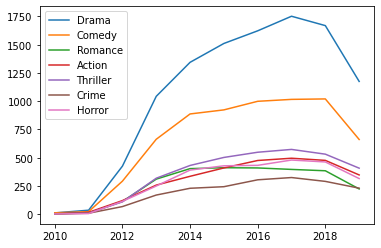

In [122]:
genres_in_years.T.plot()

In [123]:
#sprawdzenie roku 2010
genres_in_2010 = genres_split_by_years[genres_split_by_years['year']=='2010']
genres_2010=genres_in_2010['new_genre'].to_list()
genres_2010

[['Drama', ' Thriller'],
 ['Drama'],
 ['Comedy'],
 ['Comedy', ' Family'],
 ['Drama'],
 ['Action'],
 ['Animation', ' Drama', ' Family'],
 ['Comedy'],
 ['Animation', ' Adventure', ' Comedy'],
 ['Comedy', ' Romance'],
 ['Mystery', ' Thriller'],
 ['Drama', ' Horror', ' Thriller'],
 ['Comedy'],
 ['Drama', ' Musical', ' Romance'],
 ['Comedy', ' Drama', ' Romance'],
 ['Comedy'],
 ['Comedy'],
 ['Drama', ' Fantasy', ' Horror'],
 ['Action', ' Adventure', ' Music'],
 ['Drama'],
 ['Comedy', ' Crime', ' Drama'],
 ['Comedy'],
 ['Comedy', ' Crime', ' Drama'],
 ['Thriller', ' War']]

In [130]:
data_year_plot = imdb_movies.groupby('year').imdb_title_id.count()
data_year_plot.tail(20)

year
2002                3
2003                9
2004                7
2005               15
2006               14
2007               23
2008               11
2009               18
2010               24
2011               65
2012              847
2013             1916
2014             2517
2015             2764
2016             2992
2017             3223
2018             3182
2019             2168
2020              401
TV Movie 2019       1
Name: imdb_title_id, dtype: int64

# Jakie kraje dominują w produkcji filmów  - które wypuszczają najwięcej filmów, i z 5 największych zrobić szeregi czasowe - GRZESIEK

In [ ]:
import pandas as pd
imdb_movies = pd.read_csv('/content/[netflix]/IMDb movies.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
''' 
Po pierwsze, te kraje są bardzo dziwne. Po drugie nie jestem 
w stanie określić która firma produkcyjna należy do danego kraju. 
Po trzecie te wszystkie kraje pokazują gdzie filmy zostały nakręcone.
'''
imdb_movies['country'].value_counts().head(10)

USA          28511
India         6065
UK            4111
Japan         3077
France        3055
Italy         2444
Canada        1802
Germany       1396
Turkey        1351
Hong Kong     1239
Name: country, dtype: int64

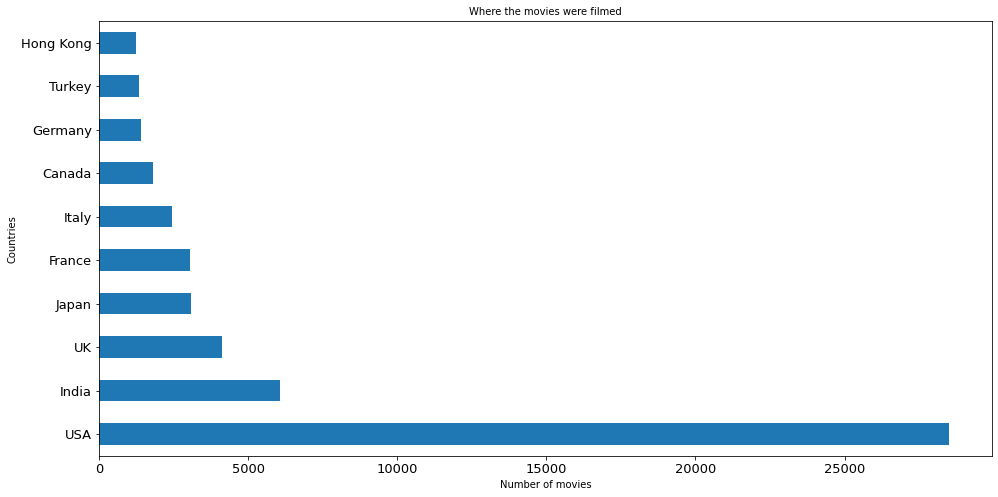

In [ ]:
'''
Te wykresy są okej, ale później jest coś nie tak...
'''
import matplotlib.pyplot as plt
import seaborn as sn
chart_country = imdb_movies['country'].value_counts().head(10)
chart_country.plot(kind='barh', figsize=(16,8), fontsize=13)
plt.title("Where the movies were filmed", fontsize=10)
plt.xlabel('Number of movies')
plt.ylabel('Countries')
plt.show()

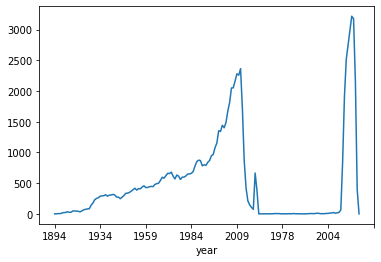

In [ ]:
'''
Jak tutaj widzimy że daty się pomieszały. Spróbowałem sortować datę i nie jestem w stanie tego naprawić.
'''
imdb_movies.groupby('year').country.count().plot()

In [ ]:
countries_new = imdb_movies[['year', 'country']]
countries_new

,year,country
0,1894,USA
1,1906,Australia
2,1911,"Germany, Denmark"
3,1912,USA
4,1911,Italy
...,...,...
85850,2020,"France, Belgium"
85851,2020,Netherlands
85852,2019,India
85853,2019,Turkey


In [ ]:
'''
Teraz sprawdzam produkcję filmu. Jak widać że czołowe firmy należą do USA oprócz Mosfilm i Canal+.
'''
imdb_movies['production_company'].value_counts().head(20)

Metro-Goldwyn-Mayer (MGM)                1284
Warner Bros.                             1153
Columbia Pictures                         914
Paramount Pictures                        903
Twentieth Century Fox                     865
Universal Pictures                        732
RKO Radio Pictures                        535
Mosfilm                                   279
Universal International Pictures (UI)     272
Canal+                                    231
Republic Pictures (I)                     208
New Line Cinema                           205
CJ Entertainment                          175
Shaw Brothers                             169
Toho Company                              158
First National Pictures                   155
Shochiku                                  144
Golden Harvest Company                    140
Touchstone Pictures                       140
Lenfilm Studio                            137
Name: production_company, dtype: int64

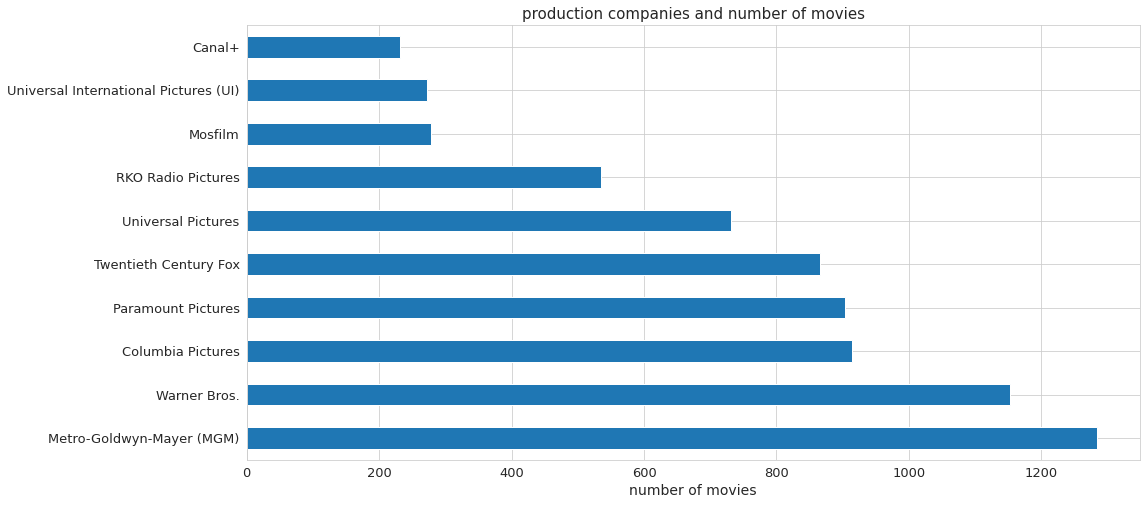

In [ ]:
imdb_production = imdb_movies['production_company'].value_counts()
imdb_production.iloc[:10].plot(kind='barh',figsize=(16,8),fontsize=13)
plt.title("production companies and number of movies",fontsize=15)
plt.xlabel('number of movies',fontsize=14)
sn.set_style("whitegrid")

In [ ]:
'''
Tutaj niestety jest za mało kolumn żeby określić w których krajach produkowali najwięcej 
filmików, więc sprawdzam które produkcje filmowe zostały najbardziej ocenione.
'''
imdb_movies.corr()

,duration,avg_vote,votes,metascore,reviews_from_users,reviews_from_critics
duration,1.000000,0.242432,0.125618,0.210531,0.130836,0.135465
avg_vote,0.242432,1.000000,0.166972,0.691338,0.138185,0.200526
votes,0.125618,0.166972,1.000000,0.194730,0.766237,0.671635
metascore,0.210531,0.691338,0.194730,1.000000,0.126131,0.236107
reviews_from_users,0.130836,0.138185,0.766237,0.126131,1.000000,0.671634
reviews_from_critics,0.135465,0.200526,0.671635,0.236107,0.671634,1.000000


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 83.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 34.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 27.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 16.1% of the points cannot be placed; yo

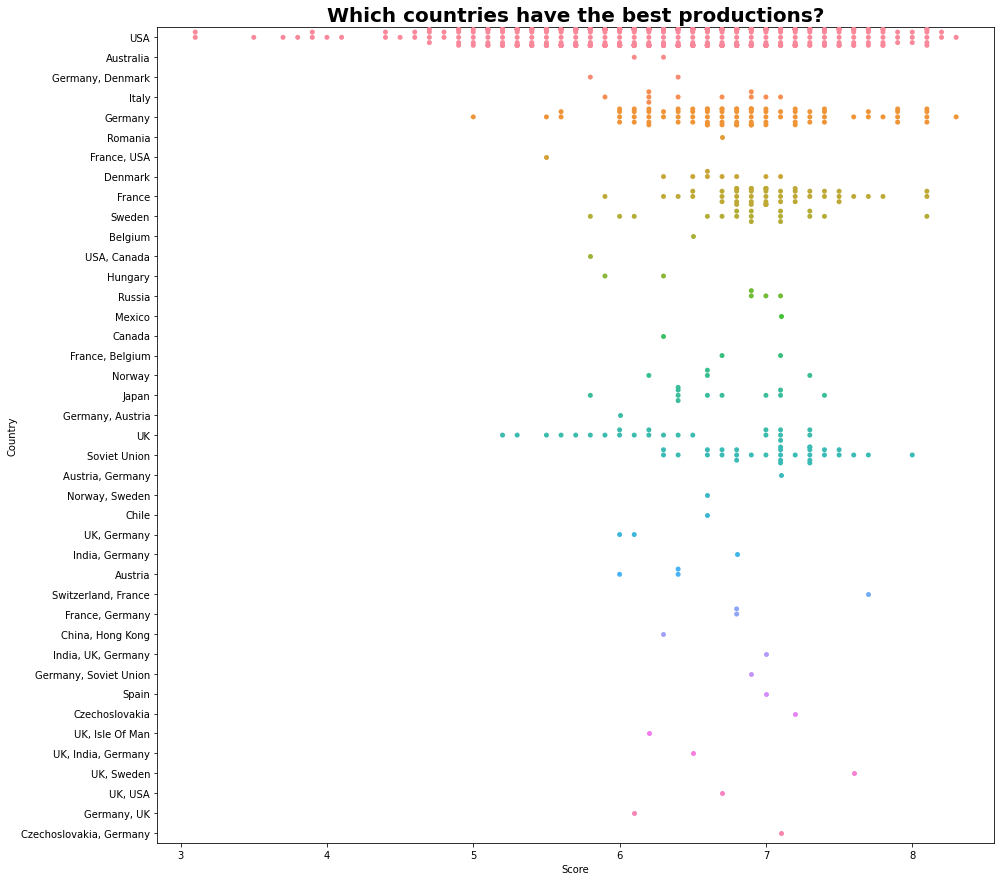

In [ ]:
movie_sliced = imdb_movies[0:1000]


plt.figure(figsize=(15,15))
sn.swarmplot(x='avg_vote', y='country', data = movie_sliced)
plt.title ('Which countries have the best productions?', fontsize=20, fontweight='bold')
plt.xlabel('Score')
plt.ylabel('Country')
plt.show()

#Ile przypadków, że scenarzysta jest jednocześnie reżyserem w filmie - EWA

In [ ]:
imdb_movies = pd.read_csv('/content/[netflix]/IMDb movies.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
imdb_movies[imdb_movies.writer == imdb_movies.director].director.count()
# to tak prosto, czyli odpowiada na postawione pytanie, 
# ale tylko wtedy jeśli jest jeden reżyser i jeden scenarzysta.

17797

In [ ]:
imdb_movies['writer_1'] = imdb_movies.writer.str.split(pat=',', expand=True)[0]
imdb_movies['writer_2'] = imdb_movies.writer.str.split(pat=',', expand=True)[1]
imdb_movies[['writer_1', 'writer_2']]

,writer_1,writer_2
0,Alexander Black,None
1,Charles Tait,None
2,Urban Gad,Gebhard Schätzler-Perasini
3,Victorien Sardou,None
4,Dante Alighieri,None
...,...,...
85850,Alexandre Coquelle,Matthieu Le Naour
85851,Radek Bajgar,Herman Finkers
85852,Vineesh Aaradya,Vineesh Aaradya
85853,Ahmet Faik Akinci,Kasim Uçkan


In [ ]:
imdb_movies['director_1'] = imdb_movies.director.str.split(pat=',', expand=True)[0]
imdb_movies['director_2'] = imdb_movies.director.str.split(pat=',', expand=True)[1]
imdb_movies[['director_1', 'director_2']]

,director_1,director_2
0,Alexander Black,None
1,Charles Tait,None
2,Urban Gad,None
3,Charles L. Gaskill,None
4,Francesco Bertolini,Adolfo Padovan
...,...,...
85850,Ludovic Colbeau-Justin,None
85851,Johan Nijenhuis,None
85852,Vineesh Aaradya,None
85853,Ahmet Faik Akinci,None


In [ ]:
# tu taki brzydki długi warunek :)
# ale wydaje mi się, że dobrze porównuje i zlicza wyżej utworzone kolumny

imdb_movies[(imdb_movies.writer_1 == imdb_movies.director_1) | 
        (imdb_movies.writer_1 == imdb_movies.director_2) | 
        (imdb_movies.writer_2 == imdb_movies.director_1) | 
        (imdb_movies.writer_2 == imdb_movies.director_2)].imdb_title_id.count()

31803

#Reżyser - z największymi średnimi głosów, największa liczba głosów - KASIA

In [16]:
imdb_movies = pd.read_csv('/content/[netflix]/IMDb movies.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
imdb_movies.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

In [89]:
#Reżyserzy z największą średnią ocen, którzy nakręcili więcej niż 5 filmów
imdb_directors_av_votes=imdb_movies[['director','avg_vote']].groupby('director').agg(['count', 'mean']).reset_index()
imdb_directors_av_votes[imdb_directors_av_votes['avg_vote']['count']>5].sort_values(by=('avg_vote','mean'), ascending=False).reset_index().head(10)

index           director avg_vote          
                               count      mean
0   5749  Christopher Nolan       11  8.218182
1  28854       Satyajit Ray       28  8.025000
2   1753   Andrei Tarkovsky        7  8.014286
3  12193     Hayao Miyazaki       12  8.008333
4  29269       Sergio Leone        7  7.928571
5  12725      Humayun Ahmed        7  7.900000
6  13739      James Cameron        7  7.885714
7  25895  Quentin Tarantino       12  7.858333
8  31398    Tengiz Abuladze        6  7.850000
9  29214          Sergey A.       24  7.850000

In [67]:
#reżyserzy, którzy kręcą dużo i źle ;)
imdb_directors_av_votes[imdb_directors_av_votes['avg_vote']['count']>10].sort_values(by=('avg_vote','mean'), ascending=True).head(10)

director avg_vote          
                          count      mean
4153       Brett Kelly       18  1.533333
26614       Rene Perez       18  2.805556
14121       Jared Cohn       16  2.943750
20607      Mark Atkins       12  3.066667
1831      Andrew Jones       24  3.241667
7102    David DeCoteau       44  3.259091
30577  Steven M. Smith       12  3.266667
6933    Daryush Shokof       11  3.318182
18975      Leigh Scott       12  3.341667
27025      Rick Sloane       11  3.400000

In [65]:
#jakie oceny dostają reżyserzy którzy idą 'na ilość'
imdb_directors_av_votes[imdb_directors_av_votes['avg_vote']['count']>5].sort_values(by=('avg_vote','count'), ascending=False).head(10)

director avg_vote          
                           count      mean
15006      Jesús Franco       87  4.718391
21840    Michael Curtiz       85  6.543529
19114   Lesley Selander       78  6.214103
19360       Lloyd Bacon       73  6.232877
33646  William Beaudine       70  5.861429
26955    Richard Thorpe       68  6.263235
15682         John Ford       67  6.710448
11306    Gordon Douglas       64  6.175000
26370       Raoul Walsh       61  6.590164
21702      Mervyn LeRoy       59  6.689831

In [88]:
#Reżyserzy których filmy otrzymują średnio najwięcej głosów, którzy nakręcili więcej niż 5 filmów
imdb_directors_sum_votes=imdb_movies[['director','votes']].groupby('director').agg(['count', 'sum']).reset_index()
imdb_directors_sum_votes['votes_per_film'] = imdb_directors_sum_votes['votes']['sum']/imdb_directors_sum_votes['votes']['count']
imdb_directors_sum_votes['votes_per_film']=imdb_directors_sum_votes['votes_per_film'].astype('int')
imdb_directors_sum_votes[imdb_directors_sum_votes['votes']['count']>5].sort_values(by=('votes_per_film'), ascending=False).head(10)

director votes           votes_per_film
                                       count       sum               
5749                 Christopher Nolan    11  11653144        1059376
25895                Quentin Tarantino    12   8458703         704891
13739                    James Cameron     7   4915763         702251
7141                     David Fincher    10   6944421         694442
25197                    Peter Jackson    13   7304418         561878
10749                     George Lucas     6   3364510         560751
2353          Anthony Russo, Joe Russo     6   3006253         501042
13336                      J.J. Abrams     6   2881528         480254
18639  Lana Wachowski, Lilly Wachowski     6   2871445         478574
34464                      Zack Snyder     8   3410835         426354

#Scenarzysta - jw - GRZESIEK

#Reżyser - dochód z filmów

##Reżyserzy z największą ilością filmów

In [ ]:
#Reżyserzy z największą ilością filmów
imdb_movies['director'].value_counts().head(10)

Jesús Franco        87
Michael Curtiz      85
Lesley Selander     78
Lloyd Bacon         73
William Beaudine    70
Richard Thorpe      68
John Ford           67
Gordon Douglas      64
Raoul Walsh         61
Mervyn LeRoy        59
Name: director, dtype: int64

##Reżyserzy, których filmy osiągnęły największy dochód na świecie - dot. dochodów w USD - może zrobić jeszcze INR rupię indyjską? Bolywood? Może filmy kręcone w Chinach (jaka waluta?) jaki mają dochód?

In [ ]:
imdb_movies['worlwide_gross_income']

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
85850    $ 3507171
85851    $ 7299062
85852          NaN
85853       $ 2833
85854      $ 59794
Name: worlwide_gross_income, Length: 85855, dtype: object

In [ ]:
#Wyczyszczenie NaN
imdb_movies['worlwide_gross_income'].replace(np.nan, '$ 0', inplace=True)

In [ ]:
#poprzez split oddzielenie waluty od wartości
imdb_movies['worlwide_gross_income']=imdb_movies['worlwide_gross_income'].apply(lambda x: x.split())


In [ ]:
#Wydzielenie walut do osobnej kolumny
imdb_movies['currency_for_wwincome']=imdb_movies['worlwide_gross_income'].apply(lambda x: x[0])

In [ ]:
#Waluty występujące w worlwide gross income
imdb_movies['currency_for_wwincome'].unique()

array(['$', 'GBP', 'INR', 'NPR', 'PKR'], dtype=object)

In [ ]:
#kolumna z worlwide gross income tylko z wartościami
imdb_movies['worlwide_gross_income']=imdb_movies['worlwide_gross_income'].apply(lambda x: x[1])

In [ ]:
#zmiana stringów na int
imdb_movies['worlwide_gross_income']=imdb_movies['worlwide_gross_income'].astype(int)

In [ ]:
#nowa df z danymi gdzie worlwide_gross_income w dolarach
imdb_movies_USD = imdb_movies[imdb_movies['currency_for_wwincome']=='$']

In [ ]:
#zmiana typu z obj na int
imdb_movies_USD['worlwide_gross_income'] =imdb_movies_USD['worlwide_gross_income'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
imdb_movies_USD['worlwide_gross_income']

In [ ]:
#Wyczyszczenie $ i spacji - tak się nie da bo różne waluty
#imdb_movies['worlwide_gross_income']=imdb_movies['worlwide_gross_income'].apply(lambda x: x[2:])


In [ ]:
#Reżyserzy z największym dochodem w dolarach
imdb_movies_USD.groupby('director').agg({'imdb_title_id':'count','worlwide_gross_income':'sum'}).reset_index().rename(columns={'imdb_title_id':'films_count'}).sort_values(by='worlwide_gross_income', ascending=False).head(20)

,director,films_count,worlwide_gross_income
30601,Steven Spielberg,32,10521265279
2352,"Anthony Russo, Joe Russo",6,6848715547
25192,Peter Jackson,13,6601458791
21769,Michael Bay,14,6451692798
13738,James Cameron,7,6185441282
7486,David Yates,8,6021255883
5748,Christopher Nolan,11,4870773767
13335,J.J. Abrams,6,4653989459
27840,Ron Howard,25,4390732419
16072,Jon Favreau,9,4348727274
